In [1]:
import pandas as pd
import numpy as np
import os, re, glob
import anndata
import scanpy as sc
import matplotlib.pyplot as plt

C:\Users\rappez\Anaconda3\lib\site-packages\anndata\_core\anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
def scale(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

def cluster(point, line1, line2, out_x, out_y):
    if (point[0] - line1[0]) * (line2[1] - line1[1]) - (point[1] - line1[1]) * (line2[0] - line1[0]) >= 0 and point[0] > out_x:
        clust_v = 'mCherry'
    elif (point[0] - line1[0]) * (line2[1] - line1[1]) - (point[1] - line1[1]) * (line2[0] - line1[0]) < 0 and point[1] > out_y:
        clust_v = 'GFP'
    else:
        clust_v = 'Undefined'
    return clust_v

def contrast(arr, low, high):
    return np.clip(arr, np.percentile(arr, low), np.percentile(arr, high))

def void2array(void):
    return pd.DataFrame(void).values

# Concatenate datasets using common annotations

In [3]:
files = glob.glob(r'F:\Experiments\Andreas_glioblastoma/*.csv')

# Find shared annotations across datasets
all_ann = []
for f in files:
    df = pd.read_csv(f)
    ind = np.where(np.array(df.columns) == 'mCherry_sampled_sum')[0][0] + 1
    all_ann = np.append(all_ann, np.array(df.columns)[ind:])

unique, counts = np.unique(all_ann, return_counts=True)
shared_ann = unique[counts >= len(files)] # See my comments on slack

# Concatenate csv's
df_all = pd.DataFrame()
for i, f in enumerate(files):
    df0 = pd.read_csv(f)
    df = df0.loc[:, shared_ann]

    df.loc[:, 'dataset'] = str(i)

    df['GFP_mean'] = df0['GFP_mean'] - np.median(df0['GFP_mean']) # dirty normalization
    df['mCherry_mean'] = df0['mCherry_mean'] - np.median(df0['mCherry_mean']) # dirty normalization

    df_all = df_all.append(df, ignore_index=True)

Fluorescence intensities have a strong batch effect. I normalized by subtracting the median intensity, which is not optimal. Ideally you should subtract the background intensity, defined as the median pixel intensity of the extracellular areas, which is computed from the cell segmentation mask (pixels of value 0 in the label image)

# Label cell types from fluorescence intensities

In [4]:
# Scale intensities between 0 and 1 and log tf
x = np.log10(scale(df_all['mCherry_mean'].values + 1))
y = np.log10(scale(df_all['GFP_mean'].values + 1))
fluo = np.array([x, y]).T

# Manually define a line which best separate mCherry positive from GFP positive cells
boundary_xy_min = [-1.55069, -1.27004] # evaluated manually
boundary_xy_max = [-1.01384, -0.703698]

# Exclude cells with ambiguous low intensities
# I chose a value which include all cells, up to you to define boundaries
min_mCherry = -5  # Minimum mCherry intensity to be used for classification
min_GFP = -5  # Minimum GFP intensity to be used for classification

# Label the cells using the defined delineating line and the exclusion limits
labels_fluo = np.array([cluster(point,
                                boundary_xy_min,
                                boundary_xy_max,
                                min_mCherry, min_GFP) for point in fluo])

C:\Users\rappez\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
C:\Users\rappez\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


(-1.3, 0)

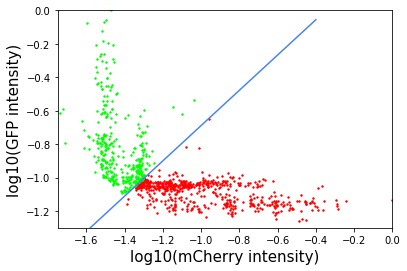

In [5]:
# Show the results
p = np.polyfit(x=[boundary_xy_min[0], boundary_xy_max[0]],
               y=[boundary_xy_min[1], boundary_xy_max[1]],
               deg=1)

plt.scatter(fluo[labels_fluo == 'mCherry', 0], fluo[labels_fluo == 'mCherry', 1], 2, color=[1, 0, 0])
plt.scatter(fluo[labels_fluo == 'GFP', 0], fluo[labels_fluo == 'GFP', 1], 2, color=[0, 1, 0])
plt.scatter(fluo[labels_fluo == 'Undefined', 0], fluo[labels_fluo == 'Undefined', 1], 2, color=[0.6, 0.6, 0.6])

plt.xlabel('log10(mCherry intensity)', fontsize=15)
plt.ylabel('log10(GFP intensity)', fontsize=15)

plt.plot((-1.75, -0.4), [p[1] + p[0] * -1.75, p[1] + p[0] * -0.4], color=[72 / 255, 133 / 255, 237 / 255],
         linewidth=1.5)
plt.xlim([-1.75, 0])
plt.ylim([-1.3, 0])

# Analyze metabolite data with Scanpy

In [6]:
def batch_prep(dataset_id='0'):

    df = df_all[df_all['dataset'] == dataset_id]
    adata = anndata.AnnData(df.loc[:, shared_ann].values)
    adata.var_names = shared_ann
    adata.obs['dataset'] = dataset_id

    # Contrast fluo intensities for visualization
    adata.obs['mCherry_plot'] = contrast(df['mCherry_mean'].values, 1, 95)
    adata.obs['GFP_plot'] = contrast(df['GFP_mean'].values, 1, 95)
    adata.obs['cell_type'] = labels_fluo[np.array(df_all['dataset'] == dataset_id)]  # Include cell type labels for differential analysis

    sc.pp.normalize_total(adata, target_sum=None)
    sc.pp.log1p(adata)

    sc.tl.pca(adata, svd_solver='arpack')

    sc.pp.scale(adata, max_value=None)

    sc.pp.neighbors(adata, n_neighbors=25, metric='cosine')  # , use_rep='X')
    sc.tl.umap(adata, min_dist=0.5)  # , init_pos=adata.obsm['X_pca'])

    sc.tl.leiden(adata, resolution=1)

    sc.pl.umap(adata, color=['leiden', 'cell_type'])
    sc.pl.pca(adata, color=['leiden', 'cell_type'])

    return adata

### Each dataset is processed indepently

C:\Users\rappez\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
C:\Users\rappez\Anaconda3\lib\site-packages\umap\umap_.py:328: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "..\..\..\..\..\Anaconda3\lib\site-packages\umap\umap_.py", line 446:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.

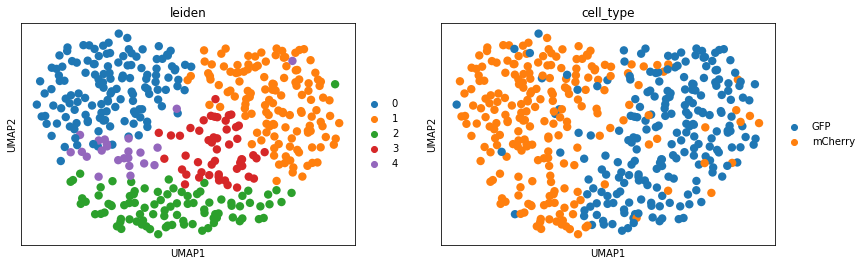

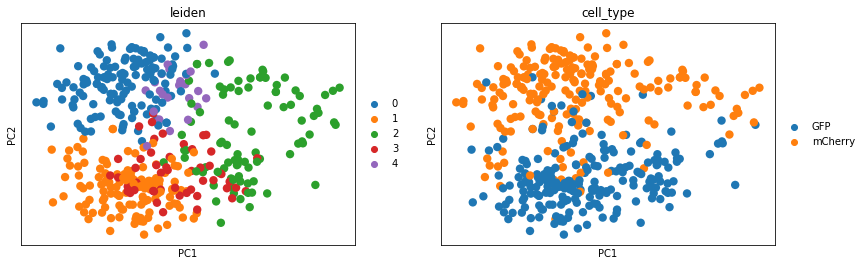

In [7]:
adata0 = batch_prep(dataset_id='0')

... storing 'dataset' as categorical
... storing 'cell_type' as categorical


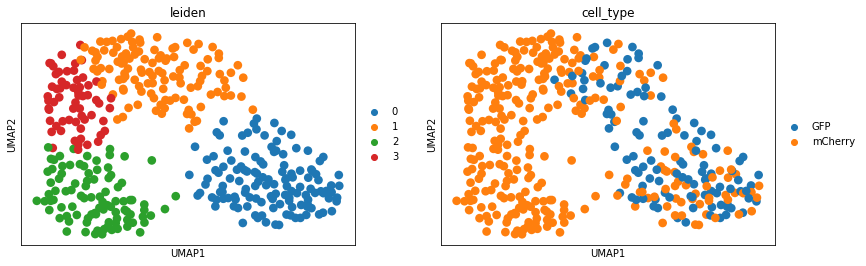

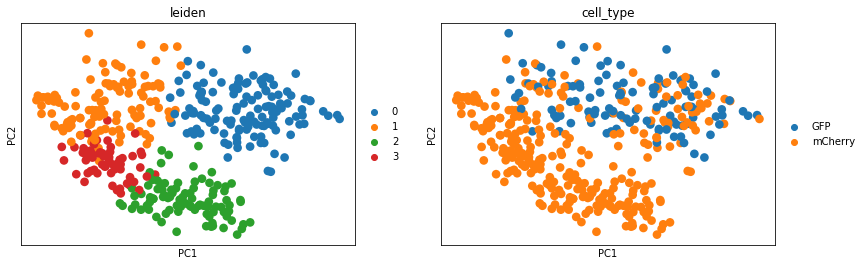

In [8]:
adata1 = batch_prep(dataset_id='1')

... storing 'dataset' as categorical
... storing 'cell_type' as categorical


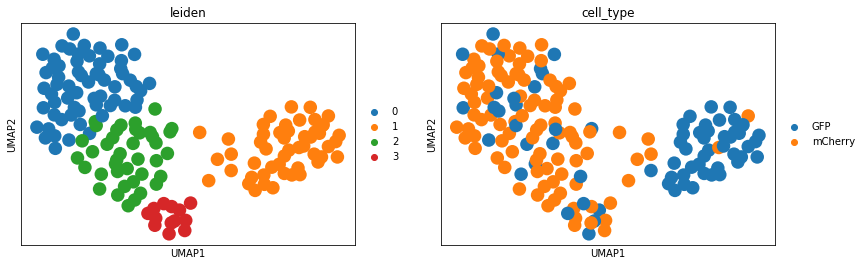

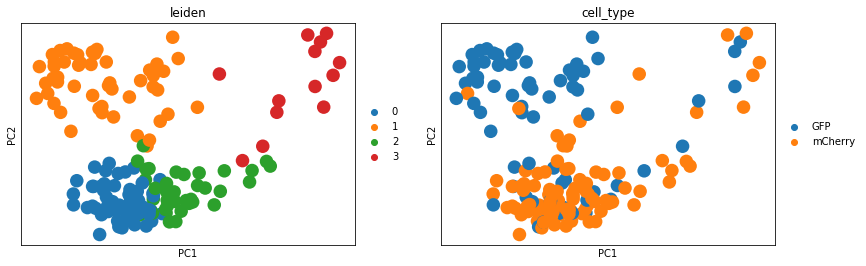

In [9]:
adata2 = batch_prep(dataset_id='2')

### Concatenate datasets and visualize in UMAP. 'batch' refers to dataset id

... storing 'dataset' as categorical


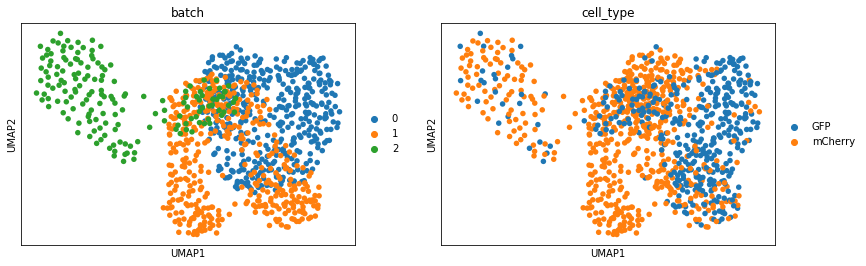

In [10]:
adata_concat = adata0.concatenate([adata1, adata2], batch_categories=['0', '1', '2'])
adata_concat.obs.leiden = adata_concat.obs.leiden.astype('category')
n_clusters = []
for adata in [adata0, adata1, adata2]:
    n_clusters.append(len(adata.obs.leiden.cat.categories))
adata_concat.obs.leiden.cat.reorder_categories(np.array([str(i) for i in range(np.max(n_clusters))], dtype='object'),
                                               inplace=True)
sc.pl.umap(adata_concat, color=['batch', 'cell_type'])

### Perform data integration with BBkNN

C:\Users\rappez\Anaconda3\lib\site-packages\umap\umap_.py:328: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "..\..\..\..\..\Anaconda3\lib\site-packages\umap\umap_.py", line 446:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
C:\Users\rappez\Anaconda3\lib\site-packages\numba\object_mode_passes.py:178: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "..\..\..\..\..\Anaconda3\lib\site-packages\umap\umap_.py", line 329:
@numba.jit()
def fuzzy_simplicial_set(
^

  state.func_ir.loc))
C:\Users\rappez\Anaconda3\lib\site-packages\numba\object_mode_passes.py:188: NumbaDeprecationWarning: 
Fall-back from the nopyt

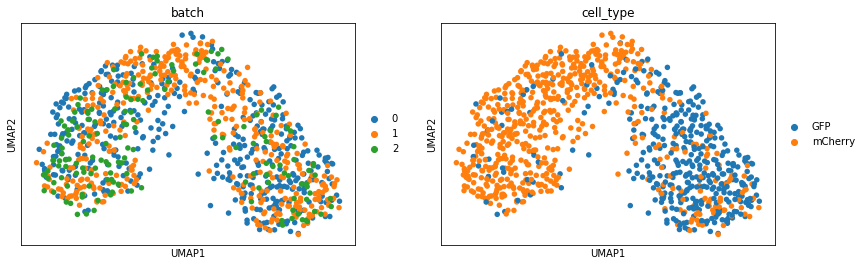

In [11]:
sc.tl.pca(adata_concat)
sc.external.pp.bbknn(adata_concat, batch_key='batch')
sc.tl.umap(adata_concat)
# sc.tl.leiden(adata_concat, resolution=0.6)
sc.pl.umap(adata_concat, color=['batch', 'cell_type'])

### Perform differential analysis to find metabolite markers for each cell type

C:\Users\rappez\Anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:252: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


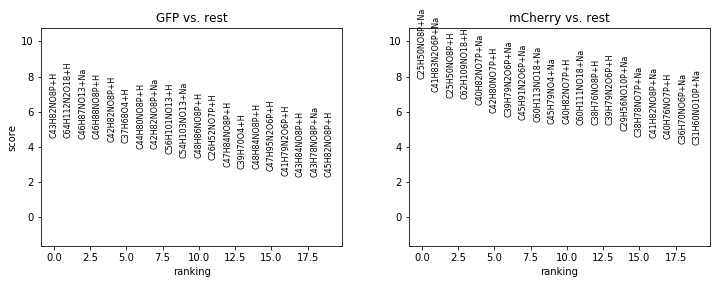

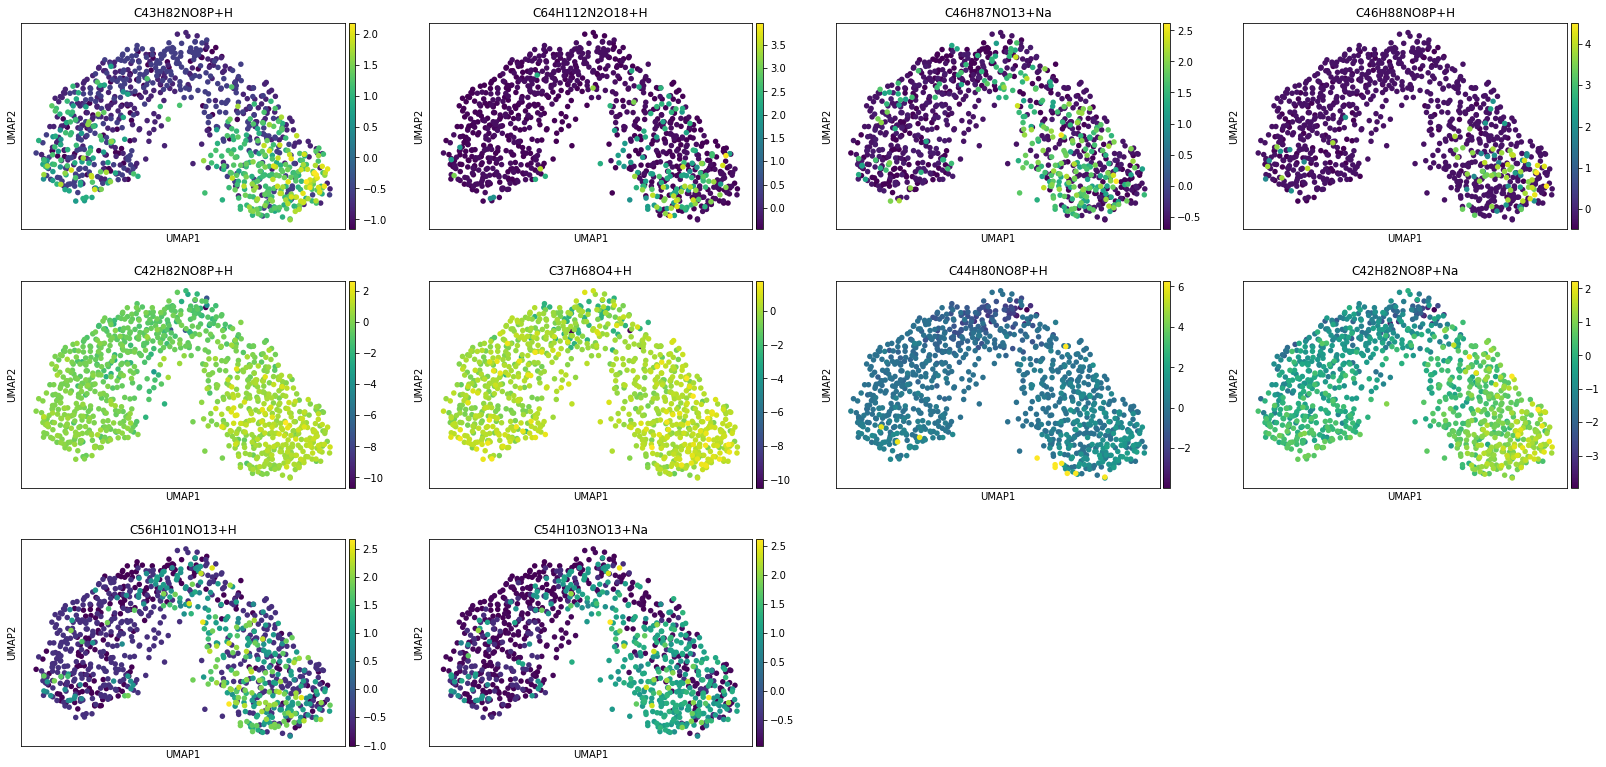

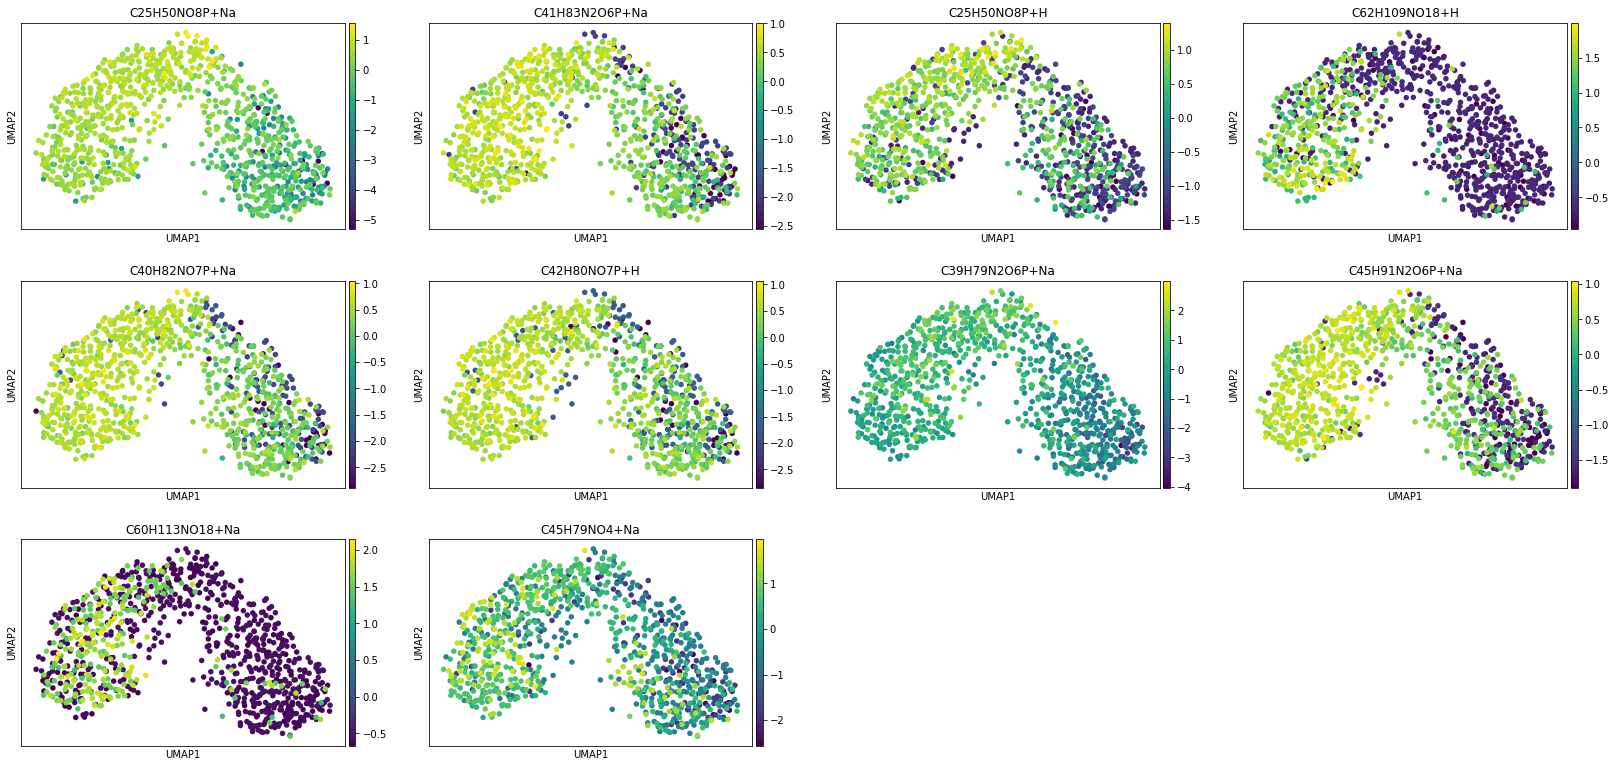

In [12]:
sc.tl.rank_genes_groups(adata, 'cell_type', method='t-test', use_raw=False)
sc.pl.rank_genes_groups(adata, sharey=True)

ranking_results = adata.uns['rank_genes_groups']
scores = void2array(ranking_results['scores'])
names = void2array(ranking_results['names'])

sc.pl.umap(adata_concat, color=names[:10, 0])
sc.pl.umap(adata_concat, color=names[:10, 1])